In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
import seaborn as sns
from tensorflow import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [2]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [3]:
df = pd.read_csv("../data/data_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

In [27]:
df.head()

,date,shops,office_building,industrial_park,fve,mve,wpg,price,isWeekend,isHoliday,...,temp,wind,hour,day,month,day_cos,day_sin,timestamp,month_cos,month_sin
0,2020-01-01 00:00:00,17.804,40.560,18.040,0.0,2708.20,90.12,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577837e+09,0.999963,-0.008601
1,2020-01-01 00:15:00,12.960,42.120,17.132,0.0,2939.06,89.54,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577838e+09,0.999965,-0.008422
2,2020-01-01 00:30:00,12.940,41.808,16.244,0.0,2923.67,81.32,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577839e+09,0.999966,-0.008243
3,2020-01-01 00:45:00,13.100,41.808,15.964,0.0,2914.28,74.89,33.2,0,1,...,-8.0,3,0,1,1,1.000000,0.000000,1.577840e+09,0.999967,-0.008064
4,2020-01-01 01:00:00,17.800,41.808,20.932,0.0,2954.06,73.86,30.4,0,1,...,-8.4,3,1,1,1,0.965926,0.258819,1.577840e+09,0.999969,-0.007884


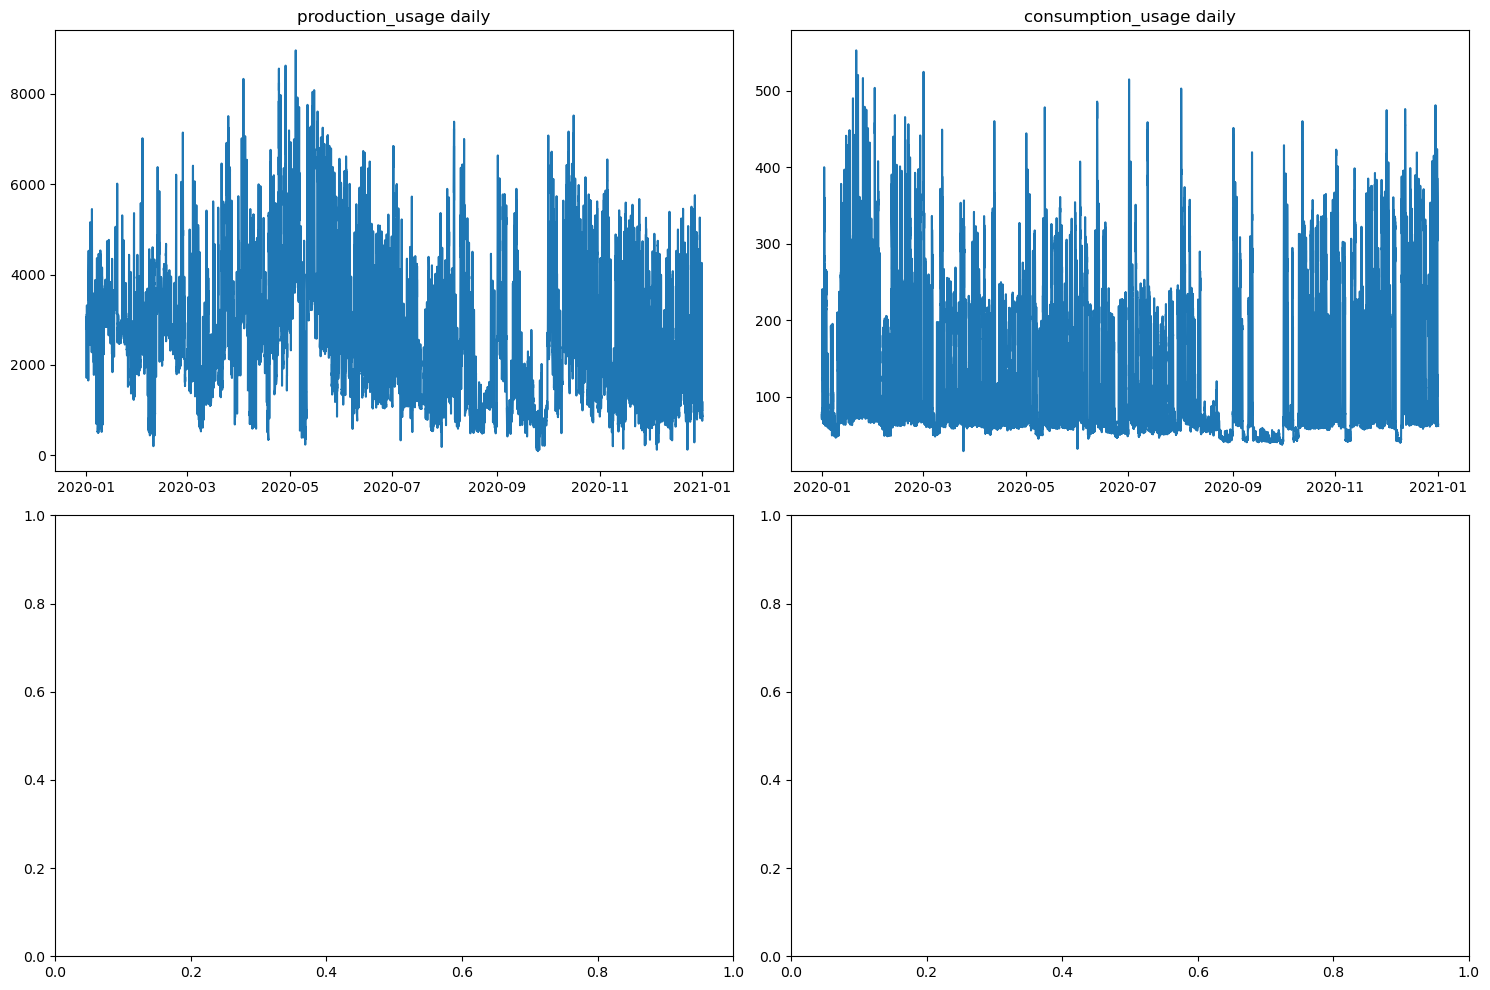

In [26]:
features = ["production_usage", "consumption_usage"]
plot_features = df.groupby('date')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} daily')
        
plt.tight_layout()

plt.show()

# PRODUCTION

In [5]:
# Number of lags (hours back) to use for models
lag = 24

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 50

# Batch size 
batch_size = 64

# Learning rate
lr = 0.0001

# Number of neurons in LSTM layer
n_layer = 10

# The features used in the modeling 
features_final = [ 'consumption_usage','price', 'isWeekend', 'isHoliday',
                  'temp', 'wind','day_cos', 'day_sin',
                  'month_cos', 'month_sin']

In [6]:
df[features_final]

,consumption_usage,price,isWeekend,isHoliday,temp,wind,day_cos,day_sin,month_cos,month_sin
0,76.404,33.20,0,1,-8.0,3,1.000000,0.000000,0.999963,-0.008601
1,72.212,33.20,0,1,-8.0,3,1.000000,0.000000,0.999965,-0.008422
2,70.992,33.20,0,1,-8.0,3,1.000000,0.000000,0.999966,-0.008243
3,70.872,33.20,0,1,-8.0,3,1.000000,0.000000,0.999967,-0.008064
4,80.540,30.40,0,1,-8.4,3,0.965926,0.258819,0.999969,-0.007884
...,...,...,...,...,...,...,...,...,...,...
35035,43.992,42.27,0,0,5.7,7,0.866025,-0.500000,0.930490,-0.366318
35036,45.552,35.30,0,0,5.4,7,0.965926,-0.258819,0.930555,-0.366151
35037,45.240,35.30,0,0,5.4,7,0.965926,-0.258819,0.930621,-0.365984
35038,44.304,35.30,0,0,5.4,7,0.965926,-0.258819,0.930687,-0.365818


In [7]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [8]:
# Subseting only the needed columns 
ts = df[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]


print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (31513, 24, 10)
Shape of the target data: (31513, 1)
Shape of validation data: (3502, 24, 10)
Shape of the validation target data: (3502, 1)


In [9]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [10]:
history = model.train()

Epoch 1/50
493/493 [==============================] - 4s 7ms/step - loss: 2.5221 - val_loss: 2.1897
Epoch 2/50
493/493 [==============================] - 3s 6ms/step - loss: 1.3118 - val_loss: 1.7434
Epoch 3/50
493/493 [==============================] - 4s 8ms/step - loss: 1.0148 - val_loss: 1.4875
Epoch 4/50
493/493 [==============================] - 4s 7ms/step - loss: 0.8298 - val_loss: 1.1834
Epoch 5/50
493/493 [==============================] - 4s 8ms/step - loss: 0.6935 - val_loss: 0.8977
Epoch 6/50
493/493 [==============================] - 4s 7ms/step - loss: 0.5983 - val_loss: 0.6808
Epoch 7/50
493/493 [==============================] - 4s 7ms/step - loss: 0.5210 - val_loss: 0.5403
Epoch 8/50
493/493 [==============================] - 4s 7ms/step - loss: 0.4540 - val_loss: 0.4709
Epoch 9/50
493/493 [==============================] - 4s 7ms/step - loss: 0.4000 - val_loss: 0.4225
Epoch 10/50
493/493 [==============================] - 3s 7ms/step - loss: 0.3512 - val_loss: 0.3816

<ipython-input-11-e93286d91971>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
<ipython-input-11-e93286d91971>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')


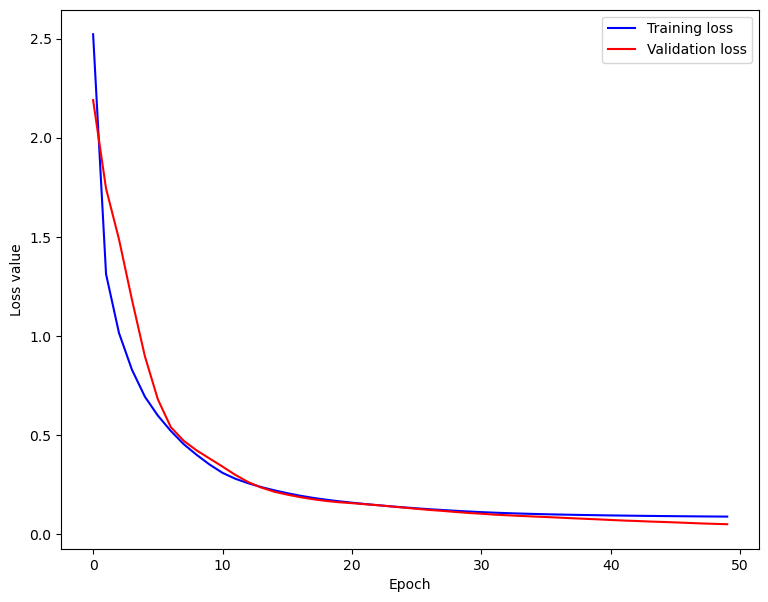

In [11]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

0.10001141959211587


<Figure size 1200x1200 with 0 Axes>

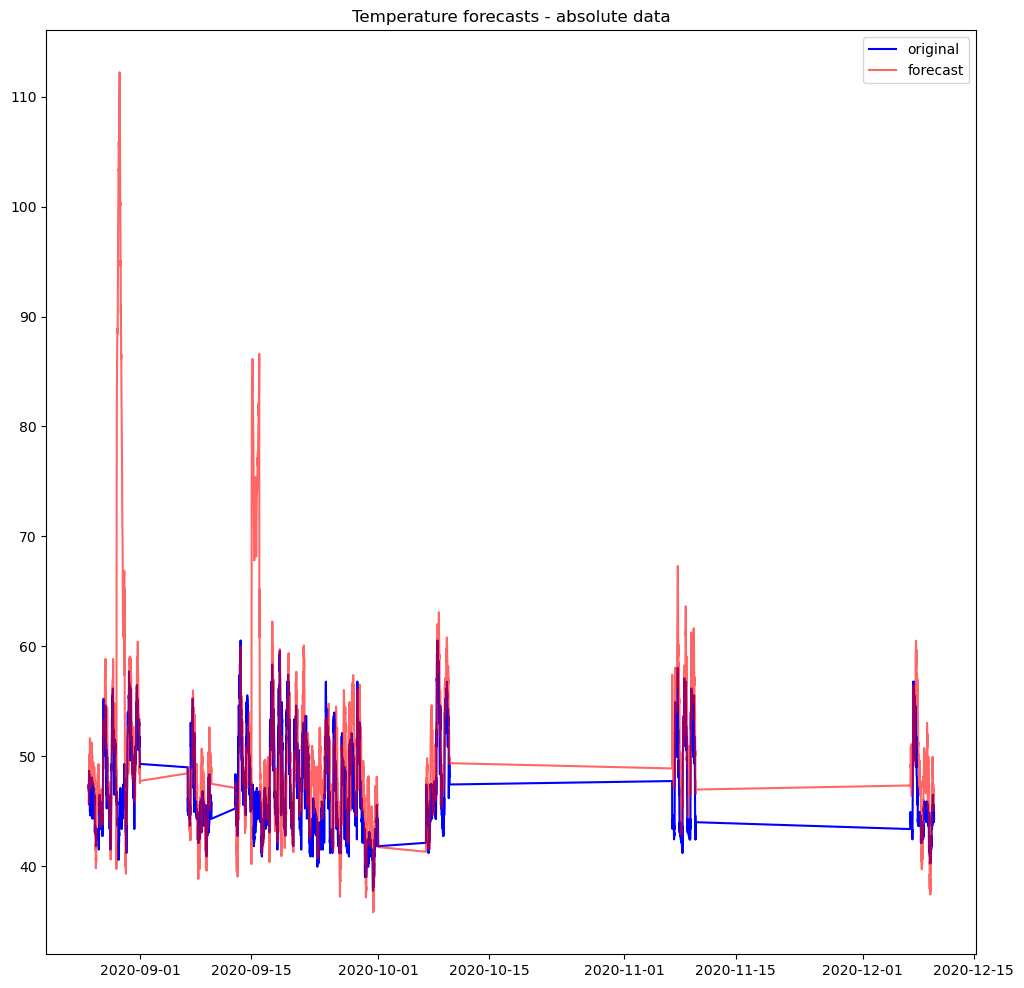

In [23]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

mse=mean_squared_error(Yval, yhat)
print(np.sqrt(mse))

# Creating the frame to store both predictions
days = df['date'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['consumption_usage_absolute'] = [(x * train_std['consumption_usage']) + train_mean['consumption_usage'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['consumption_usage_absolute_original'] - pivoted['consumption_usage_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.consumption_usage_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.consumption_usage_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()